<a href="https://colab.research.google.com/github/ebriggsjohnson/MSQM_Contest/blob/main/DOTRC_Social_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Using BERT for Social Analytics in Dream of the Red Chamber

The Dream of the Red Chamber is one of the "Four Great Novels" in China. Written in the late 1700s, it has fascinated both scholars and the reading public since its publishing. It is technically written in Modern Chinese, but the langauge has changed a lot since then, and its dense references to everything from Buddhism to Imperial politics to tea make it a challenge for foreign readers like myself. The cast of characters is also huge. It becomes a challenge to keep track of them, especially if your mind has been destroyed by too much exposure to the internet and AI slop. But maybe we can use our poisoner to help us? I am proposing using a large language model and neural networks to graph relationships between characters, where the user can further selection how many chapters they have read up to that point as a refresher of who is who, and what their relationship is. The idea of a visual social network between characters is not new. But by automating it and making it interactive, it may be a more useful tool to students, researchers, and so on. The wealth of human knowledge is contained in our fiction -- if we can understand it more thoroughly, I think the implications can apply to any business or nonprofit endeavor that involves human relationships, particularly those working in media.


My inspirations:
https://aclanthology.org/2024.paclic-1.23.pdf -- I found this paper after I came up the idea. Their end product is similar to what I trying to build. They did a better job. But hey, they are pros and I did it in a day...

Professor Wei's class in advanced data analytics for giving my first glimpse into how LLM's actually work. The first sip of the ocean.

Cao Xueqin - the GOAT Chinese novelist -- for writing such a killer book.

## My Main Idea

How can we use a model to graph what characters relate to anothe? My initial attempts to use various Hugging Face models to graph relationships with explicit terms like friend, lover, etc went really poorly. My idea was to make the problem simple, and get a simple end result. So what do we do?

The full details of how I implemented it are below, but the main idea is -- characters that are related probably talk to each other a lot. Unfortunately, sentences aren't tagged with "A" talked to B". But they do have pronouns, and BERT is good at guessing what words refer to. So we hardcode a list of characters, mask the pronouns, and then have Bert guess who the masked word most likely refers to. If a bunch of pronouns referring to Bill occur near a bunch of pronouns referring to Jane, then that's a relationship. At least I hope so!

The pronoun-resolution component uses a masked language model (BERT) to test which character name best fits a pronoun in context. For each pronoun occurrence, the model temporarily replaces the pronoun with a candidate character name, masks the inserted characters, and measures how likely the language model is to predict those characters in that sentence. Candidates with higher summed log-probabilities are considered more plausible referents and are accepted if they pass a threshold. To keep the process computationally feasible, candidates are restricted to the most frequently mentioned characters and evaluated in GPU batches. The resolved pronouns are then treated as additional character mentions and incorporated into the co-occurrence graph.

## Pronoun Resolution Model

Pronouns are resolved using a masked language model (MLM), specifically a pretrained Chinese BERT model. The method selects the character name that makes the surrounding sentence most probable when the pronoun is replaced.

---

### Problem setup

Let:

- $s$ denote a sentence containing a pronoun at position $p$
- $C = \{c_1, c_2, \dots, c_K\}$ be a set of candidate character names
- $c = (c_1, c_2, \dots, c_m)$ be a candidate name consisting of $m$ characters

The goal is to estimate:

$$
\arg\max_{c \in C} P(c \mid s \setminus p)
$$

that is, which candidate name is most likely given the sentence context with the pronoun removed.

---

### Masked language model scoring

For each candidate $c$, replace the pronoun by the candidate name and mask each inserted character position. The MLM is used to estimate the probability of the masked characters.

The score for candidate $c$ is approximated as

$$
\mathrm{Score}(c) = \sum_{i=1}^{m} \log P(c_i \mid s_{[\mathrm{MASK}]_i})
$$

where $c_i$ is the $i$-th character of the candidate name and $s_{[\mathrm{MASK}]_i}$ is the sentence with the $i$-th character masked. The sum of log-probabilities approximates the joint likelihood of the candidate name in context.

---

### Decision rule

A candidate is accepted if

$$
\mathrm{Score}(c) > \tau
$$

where $\tau$ is a threshold chosen empirically. If multiple candidates exceed $\tau$, the highest-scoring candidate is selected.

---

### Practical constraints

To make the method tractable:

- The candidate set $C$ is limited to the top-$K$ most frequent character names.
- Examples are evaluated in GPU batches.
- Very long sentences are skipped to avoid tokenization truncation and mask misalignment.

---

### Integration into the network

Accepted pronoun resolutions are appended to the mention list as additional character mentions. These augmented mentions are then used to construct a character co-occurrence network, where edges reflect textual proximity rather than narrative or emotional importance, but our hypothesis is that the former will imply the latter.

In [1]:
#load data
from google.colab import drive
drive.mount('/content/drive')

TEXT_PATH = '/content/drive/My Drive/dotrc_analytics_project/红楼梦.txt'
CHAR_CSV  = '/content/drive/My Drive/dotrc_analytics_project/hlm_chars.csv'

with open(TEXT_PATH, 'r', encoding='utf-8') as f:
    text = f.read()

import pandas as pd
chars_df = pd.read_csv(CHAR_CSV, encoding='utf-8', dtype=str).fillna('')

print("Loaded text chars:", len(text))
print("Loaded chars:", len(chars_df), "cols:", list(chars_df.columns))





Mounted at /content/drive
Loaded text chars: 858628
Loaded chars: 45 cols: ['english_name', 'simplified_chinese_name', 'description']


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-noto-cjk.
(Reading database ... 121689 files and directories currently installed.)
Preparing to unpack .../fonts-noto-cjk_1%3a20220127+repack1-1_all.deb ...
Unpacking fonts-noto-cjk (1:20220127+repack1-1) ...
Setting up fonts-noto-cjk (1:20220127+repack1-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
CJK font registered as: Noto Sans CJK JP
Matplotlib font.family: ['sans-serif']
Matplotlib font.sans-serif[0]: Noto Sans CJK JP


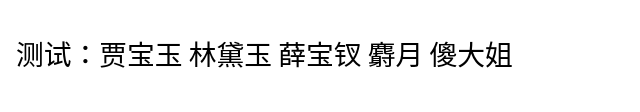

In [2]:
# ===== FORCE Matplotlib + NetworkX to use Noto CJK (no DejaVu fallback) =====
!apt-get -qq update
!apt-get -qq install -y fonts-noto-cjk

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

CJK_FONT_PATH = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"

# Register font
fm.fontManager.addfont(CJK_FONT_PATH)
CJK_NAME = fm.FontProperties(fname=CJK_FONT_PATH).get_name()

# Force Matplotlib defaults + sans-serif fallback order
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = [CJK_NAME]   # <-- critical line
plt.rcParams["axes.unicode_minus"] = False

print("CJK font registered as:", CJK_NAME)
print("Matplotlib font.family:", plt.rcParams["font.family"])
print("Matplotlib font.sans-serif[0]:", plt.rcParams["font.sans-serif"][0])

# Proof
plt.figure(figsize=(8,1.2))
plt.text(0.01, 0.4, "测试：贾宝玉 林黛玉 薛宝钗 麝月 傻大姐", fontsize=20)
plt.axis("off")
plt.show()

In [3]:
import re, time, math  # regex + timing + math
import torch  # pytorch
from collections import Counter, defaultdict  # counting helpers
from transformers import AutoTokenizer, AutoModelForMaskedLM  # HF tokenizer + masked LM

device = "cuda" if torch.cuda.is_available() else "cpu"  # pick GPU if possible

MODEL_NAME = "bert-base-chinese"  # model checkpoint name
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)  # load tokenizer
model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME).to(device)  # load model and move to device
model.eval()  # inference mode

zh_names = [s.strip() for s in chars_df["simplified_chinese_name"].tolist() if str(s).strip()]  # read Chinese names from CSV
zh_names = sorted(set(zh_names), key=len, reverse=True)  # dedupe + sort by length (longest first)
name_re = re.compile("|".join(map(re.escape, zh_names)))  # build regex that matches any name safely

mentions_seed = [(m.start(), m.group()) for m in name_re.finditer(text)]  # seed mentions from exact name matches

K_CANDIDATES = 25  # how many candidate names to try per pronoun
seed_counts = Counter(n for _, n in mentions_seed)  # count how often each name appears explicitly
top_candidates = [n for n, _ in seed_counts.most_common(K_CANDIDATES)]  # take top-K frequent names as candidates

pron_re = re.compile(r"(他|她|他们|她们)")  # 3rd-person pronouns only
sent_re = re.compile(r"[^。！？\n]+[。！？\n]?")  # rough sentence splitter

BATCH_SIZE   = 1024  # batch size for masked examples (bigger = faster until OOM)
MAX_LENGTH   = 192   # max token length for BERT input
MAX_PRONOUNS = 60000 # cap how many pronoun occurrences we consider
TAU          = -25.0 # accept only if best score is above this threshold

occ = []  # store pronoun occurrences as (global_pos, sentence_text, pron_char_index)
MAX_SENT_CHARS = 700  # skip very long sentences to avoid heavy truncation

for m in sent_re.finditer(text):  # iterate sentence-like chunks in the full text
    s0 = m.start()  # global char offset of this sentence start
    s = m.group()  # actual sentence text
    if len(s) > MAX_SENT_CHARS:  # skip overly long sentences
        continue
    for pm in pron_re.finditer(s):  # find all target pronouns in this sentence
        occ.append((s0 + pm.start(), s, pm.start()))  # save global pos + sentence + local pronoun index

import random  # for shuffling
random.seed(42)  # deterministic shuffle
random.shuffle(occ)  # randomize order so the cap samples across the book
occ = occ[:MAX_PRONOUNS]  # keep only the first MAX_PRONOUNS pronoun occurrences

def gen_examples():  # generator that streams masked examples without storing them all
    for gpos, sent, p in occ:  # loop over each pronoun occurrence we sampled
        s_chars = list(sent)  # split sentence into characters for splicing
        if p < 0 or p >= len(s_chars):  # guard against bad indices
            continue
        for cand in top_candidates:  # try each candidate character name
            new_chars = s_chars[:p] + list(cand) + s_chars[p+1:]  # replace the 1-char pronoun with multi-char candidate
            masked = new_chars.copy()  # copy for masking
            for k in range(len(cand)):  # for each character inserted by the candidate name
                masked[p+k] = tokenizer.mask_token  # replace that character with [MASK]
            masked_sent = "".join(masked)  # rebuild a single masked sentence string

            tgt_ids = []  # will hold token ids for the candidate characters
            ok = True  # flag for whether we can score this candidate
            for ch in cand:  # loop over each Chinese character in the candidate name
                ids = tokenizer(ch, add_special_tokens=False)["input_ids"]  # tokenize single character
                if not ids:  # if tokenizer can’t produce a token id, skip this candidate
                    ok = False
                    break
                tgt_ids.append(int(ids[0]))  # take the first token id (Chinese chars usually map to 1 token)
            if not ok:  # skip candidates with bad characters
                continue

            yield (gpos, cand, masked_sent, tgt_ids)  # emit one masked example for (pronoun occurrence × candidate)

best_by_pos = {}  # maps pronoun global position -> (best_candidate, best_score)
g = gen_examples()  # create generator instance

t0 = time.time()  # start timer
processed = 0  # how many masked examples (pronoun×candidate pairs) processed so far

while True:  # keep reading and scoring until generator is exhausted
    batch = []  # buffer for one batch of examples
    try:
        while len(batch) < BATCH_SIZE:  # fill the batch
            batch.append(next(g))  # get next example from generator
    except StopIteration:  # generator ran out
        if not batch:  # if nothing left to process, exit
            break

    masked_texts = [x[2] for x in batch]  # extract masked sentence strings from this batch

    enc = tokenizer(  # tokenize the batch for BERT
        masked_texts,  # the list of masked sentences
        return_tensors="pt",  # return PyTorch tensors
        padding=True,  # pad sentences to same length in batch
        truncation=True,  # truncate sentences that exceed max length
        max_length=MAX_LENGTH  # cap token length for speed/memory
    ).to(device)  # move tensors to GPU/CPU

    with torch.no_grad():  # inference only
        if device.startswith("cuda"):  # if GPU
            with torch.autocast(device_type="cuda", dtype=torch.float16):  # use fp16 for speed + memory
                logits = model(**enc).logits  # forward pass; logits shape (B, seq_len, vocab)
        else:  # CPU case
            logits = model(**enc).logits  # forward pass without autocast

    input_ids = enc["input_ids"]  # token ids for each example in batch
    mask_id = tokenizer.mask_token_id  # token id for [MASK]

    for b_idx, (gpos, cand, _, tgt_ids) in enumerate(batch):  # loop over each example in the batch
        mask_pos = (input_ids[b_idx] == mask_id).nonzero(as_tuple=True)[0].tolist()  # positions of [MASK] tokens
        if len(mask_pos) < len(tgt_ids):  # if truncation or tokenization caused fewer masks than expected
            continue
        mask_pos = mask_pos[:len(tgt_ids)]  # align first N masks to N target characters

        score = 0.0  # sum of log-probs for the candidate name
        for mp, tgt in zip(mask_pos, tgt_ids):  # for each mask position and corresponding target token id
            score += torch.log_softmax(logits[b_idx, mp, :], dim=-1)[tgt].item()  # add log P(target | context)

        cur = best_by_pos.get(gpos)  # current best for this pronoun position (if any)
        if (cur is None) or (score > cur[1]):  # if first time seeing this position, or we beat prior best
            best_by_pos[gpos] = (cand, float(score))  # store new best candidate and score

    processed += len(batch)  # count examples processed
    if processed % (BATCH_SIZE * 10) == 0:  # periodic progress print
        print("processed:", processed, "unique pronouns:", len(best_by_pos), "elapsed:", round(time.time() - t0, 1), "s")

resolved_best = [(pos, cand) for pos, (cand, sc) in best_by_pos.items() if sc > TAU]  # keep only best candidates above threshold
mentions = mentions_seed + resolved_best  # final mention list = explicit name mentions + resolved pronoun mentions

print("resolved:", len(resolved_best))  # how many pronoun mentions were added
print("total mentions:", len(mentions))  # total mentions used for graph building
print("top mentions:", Counter(n for _, n in mentions).most_common(10))  # most frequent names after augmentation

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if 

processed: 10240 unique pronouns: 410 elapsed: 5.8 s
processed: 20480 unique pronouns: 820 elapsed: 11.0 s
processed: 30720 unique pronouns: 1229 elapsed: 16.6 s
processed: 40960 unique pronouns: 1639 elapsed: 22.0 s
processed: 51200 unique pronouns: 2048 elapsed: 27.3 s
processed: 61440 unique pronouns: 2458 elapsed: 33.1 s
processed: 71680 unique pronouns: 2868 elapsed: 38.4 s
processed: 81920 unique pronouns: 3277 elapsed: 43.6 s
processed: 92160 unique pronouns: 3687 elapsed: 49.2 s
processed: 102400 unique pronouns: 4096 elapsed: 54.7 s
processed: 112640 unique pronouns: 4506 elapsed: 60.1 s
processed: 122880 unique pronouns: 4916 elapsed: 65.8 s
processed: 133120 unique pronouns: 5325 elapsed: 71.0 s
processed: 143360 unique pronouns: 5735 elapsed: 76.3 s
processed: 153600 unique pronouns: 6144 elapsed: 82.0 s
processed: 163840 unique pronouns: 6554 elapsed: 87.3 s
processed: 174080 unique pronouns: 6964 elapsed: 92.6 s
processed: 184320 unique pronouns: 7373 elapsed: 98.2 s
reso

In [4]:
# import networkx for graph construction
import networkx as nx

# Counter used for counting mentions and co-occurrences
from collections import Counter

# keep only the top N characters by total mention frequency
MAX_NODES = 40

# count how many times each character appears in the mentions list
name_counts = Counter(n for _, n in mentions)

# select the top MAX_NODES most frequent characters
top_names = [n for n,_ in name_counts.most_common(MAX_NODES)]

# convert to set for fast membership checks
top_set = set(top_names)

# filter mentions to only those involving the top characters
# then sort by position in the text
mentions_top = sorted(
    [(p,n) for p,n in mentions if n in top_set],
    key=lambda x: x[0]
)

# size of the fixed character window used for co-occurrence
WINDOW_CHARS = 280

# minimum number of co-occurrences required to keep an edge
MIN_EDGE_COUNT = 3

# Counter to store how many times each character pair co-occurs
pair_counts = Counter()

# total number of mentions after filtering
n = len(mentions_top)

# pointer for the sliding window
j = 0

# iterate through mentions using an anchor index i
for i in range(n):
    pi, ai = mentions_top[i]        # position and character at anchor
    if j < i+1:                     # ensure j always stays ahead of i
        j = i+1
    # advance j while mentions are within WINDOW_CHARS of anchor
    while j < n and (mentions_top[j][0] - pi) <= WINDOW_CHARS:
        j += 1
    # collect unique character names in the current window
    names_in_window = set([ai] + [mentions_top[k][1] for k in range(i+1, j)])
    # skip windows with fewer than two unique characters
    if len(names_in_window) < 2:
        continue
    # sort names so pair ordering is consistent
    lst = sorted(names_in_window)
    # count each unordered pair once for this window
    for x in range(len(lst)):
        for y in range(x+1, len(lst)):
            pair_counts[(lst[x], lst[y])] += 1

# create an undirected graph
G = nx.Graph()

# add nodes with their total mention counts as a node attribute
for nname in top_names:
    G.add_node(nname, mentions=int(name_counts.get(nname, 0)))

# add edges for character pairs that co-occur often enough
for (a,b), c in pair_counts.items():
    if c >= MIN_EDGE_COUNT:
        # edge weight is log-scaled to prevent domination by very frequent pairs
        G.add_edge(a, b, count=int(c), weight=float(math.log(c + 1)))

# print basic graph statistics
print("G nodes:", G.number_of_nodes(), "edges:", G.number_of_edges())

G nodes: 40 edges: 484


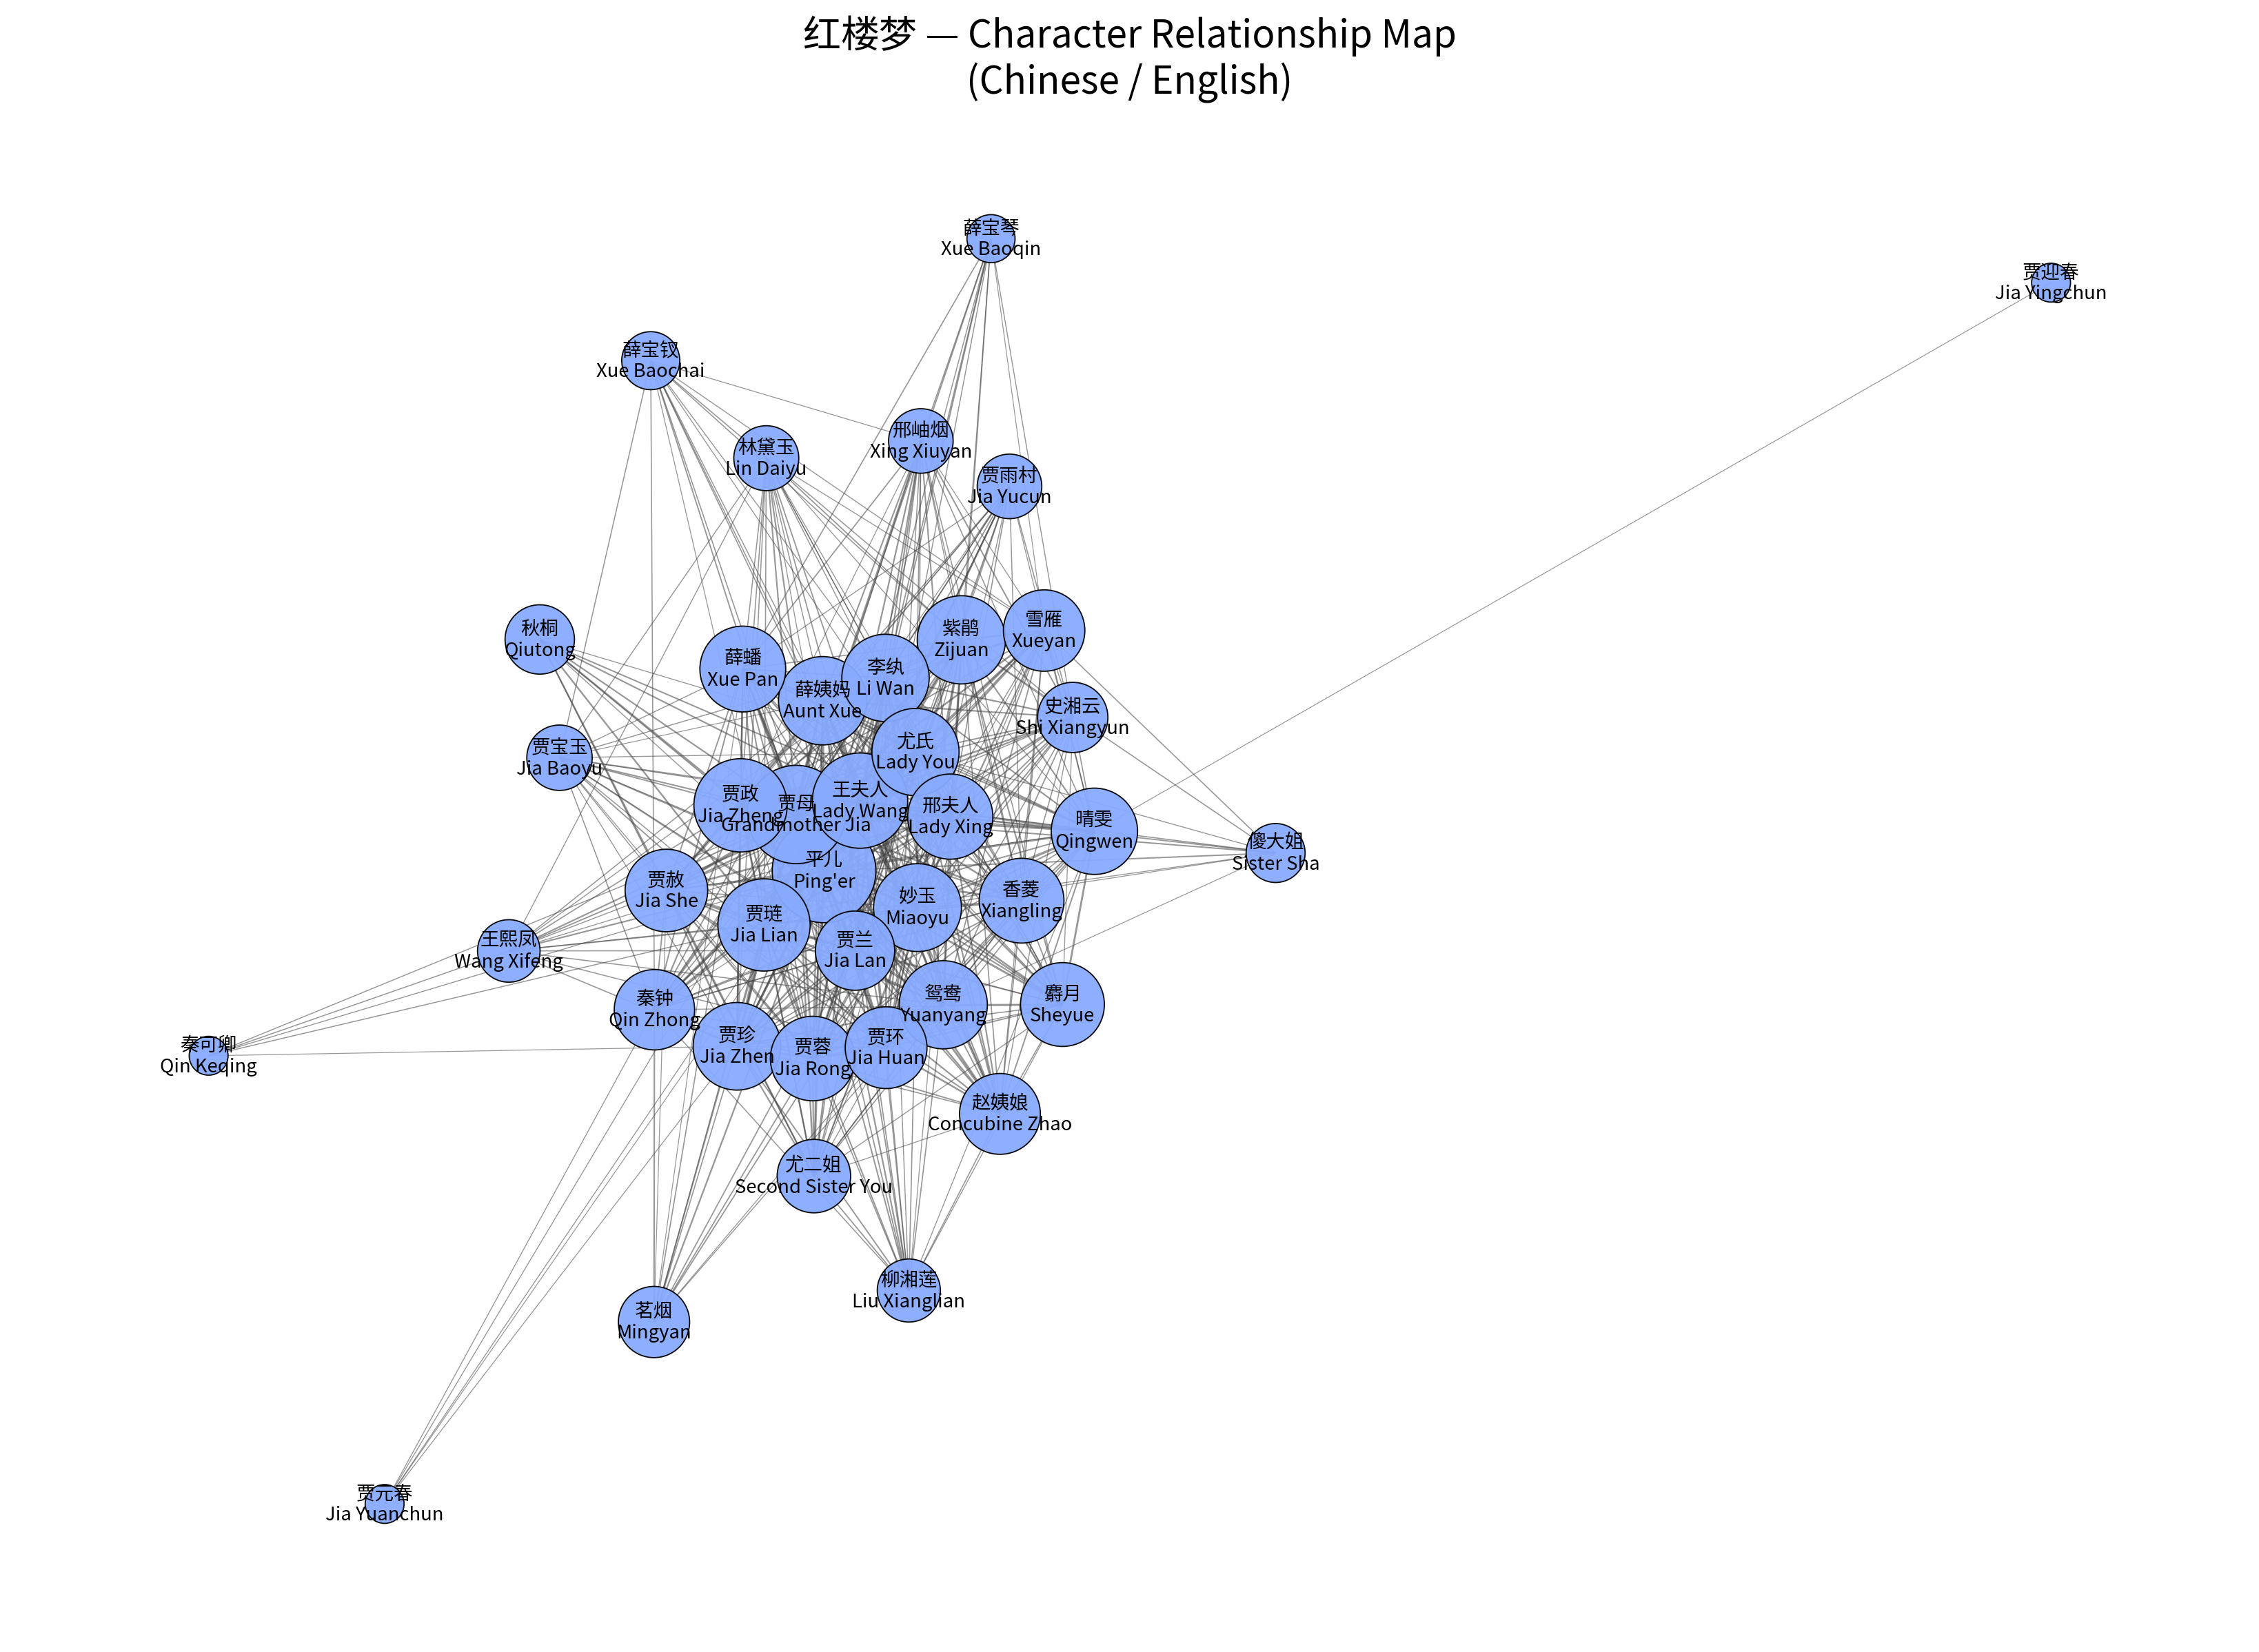

Saved: /content/hlm_relation_map_bilingual.png
Saved: /content/hlm_relation_map_bilingual.svg
Font used: Noto Sans CJK JP


In [5]:
import math
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.font_manager as fm

# ---- Ensure CJK_NAME exists (no DejaVu fallback) ----
try:
    CJK_NAME
except NameError:
    CJK_FONT_PATH = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
    fm.fontManager.addfont(CJK_FONT_PATH)
    CJK_NAME = fm.FontProperties(fname=CJK_FONT_PATH).get_name()
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.sans-serif"] = [CJK_NAME]
    plt.rcParams["axes.unicode_minus"] = False

# ---- Build bilingual labels (中文\nEnglish) ----
zh2en = {}
for _, row in chars_df.iterrows():
    zh = str(row.get("simplified_chinese_name","")).strip()
    en = str(row.get("english_name","")).strip()
    if zh:
        zh2en[zh] = en

labels = {}
for n in G.nodes():
    en = zh2en.get(n, "")
    labels[n] = f"{n}\n{en}" if en else n

# ---- If pos missing or wrong type, compute stable layout ----
if ("pos" not in globals()) or (not isinstance(pos, dict)) or (len(pos) != G.number_of_nodes()):
    pos = nx.kamada_kawai_layout(G, weight="weight")
    pos = nx.spring_layout(G, pos=pos, iterations=150, weight="weight", seed=42)

# ---- Draw ----
plt.figure(figsize=(15,11), dpi=220)
ax = plt.gca()
ax.set_facecolor("white")

# node sizes from mentions (log)
node_sizes = []
for n in G.nodes():
    m = G.nodes[n].get("mentions", 1)
    node_sizes.append(160 + math.log(m + 1) * 260)  # slightly larger bubbles

# thin edges from log-weight (stable + not crazy thick)
edge_widths = []
for u, v in G.edges():
    w = float(G[u][v].get("weight", 1.0))           # weight = log(count+1)
    edge_widths.append(0.25 + 0.55 * (w / 5.0))     # thin like your good version

nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color="#88aaff",
    edgecolors="black",
    linewidths=0.6,
    alpha=0.95
)

nx.draw_networkx_edges(
    G, pos,
    width=edge_widths,
    edge_color="#444444",
    alpha=0.55
)

nx.draw_networkx_labels(
    G, pos,
    labels=labels,
    font_size=9,
    font_family=CJK_NAME
)

plt.axis("off")
plt.title("红楼梦 — Character Relationship Map\n(Chinese / English)", fontsize=18)
plt.tight_layout()

OUT_PNG = "/content/hlm_relation_map_bilingual.png"
OUT_SVG = "/content/hlm_relation_map_bilingual.svg"
plt.savefig(OUT_PNG, dpi=300)
plt.savefig(OUT_SVG)
plt.show()

print("Saved:", OUT_PNG)
print("Saved:", OUT_SVG)
print("Font used:", CJK_NAME)

## Our Results
This graph should be read as a map of who shows up together in the text, not who matters most emotionally or symbolically. The dense core around Grandmother Jia, Lady Wang, Wang Xifeng, Jia Lian, Jia Zheng, and a group of senior maids makes sense, since these are the people who are physically present across the widest range of scenes. Servants like Ziyuan, Yuanyang, Ping’er, Qingwen, and Sheyue end up looking especially central, which feels a little odd at first but actually lines up with how the novel works: they move between rooms, relay information, and are often present when other characters come and go. Characters who are crucial to the plot or themes but appear in more contained narrative arcs don’t dominate the network, which is more a limitation of the method than a mistake. Using a language model to resolve pronouns helps fill in missing references and makes the graph less sparse, but it also flattens distinctions by pulling many characters into the same social space.

Jia Yingchun is socially peripheral, which is reflected in the graph. She’s quiet, passive, and largely sidelined in the household. Most of her scenes are short, domestic, and often mediated through others rather than driven by her own dialogue. She doesn’t move between social spaces the way Baoyu, Xifeng, or the maids do, so she simply doesn’t co-occur with many different characters in a tight textual window.

Jia Yuanchun (贾元春) is even more extreme. Despite her symbolic importance, she appears in very few scenes and is mostly present through description, memory, or ritualized events (most notably the imperial visit). She doesn’t participate in everyday household interactions, which is exactly what your model is measuring. From the graph’s point of view, she barely “lives” in the same textual space as the rest of the cast.

Qin Keqing (秦可卿) is isolated in our graph, and she dies early in the novel. So she isn't referenced by the main mass. Again, makes sense.

## My Broad Takeaways

The biggest limitation is that the model only sees proximity in the text. It can’t tell the difference between someone speaking, someone being spoken about, or someone just being in the background of a scene. Even with a “best candidate only” rule, pronoun resolution adds noise and blurs differences between frequently mentioned characters. The results are also sensitive to choices like window size, thresholds, and candidate limits, and small tweaks can noticeably change the structure. Overall, this should be seen as an exploratory visualization rather than a definitive account of character relationships. I’m not completely happy with the result, but I’m glad I got it working, and I think it’s a promising way to use machines to surface patterns in literary texts, even if it still needs a lot of care and interpretation.